# Class 4a

1. Permutation Tests
2. Binary Processes
    * AB Tests
    * Binomial Distribution


In [2]:
%run ./ourFunctions.py
%precision 3

'%.3f'

### Permutation 2-sample test

We have used the bootstrap to compare two sets of data, both of which are samples. In particular, we can test two-sample hypotheses such as  

$H_0: \mu_m = \mu_f, H_A: \mu_m \neq \mu_f$

or the one-sided versions:

$H_0: \mu_m = \mu_f, H_A: \mu_m > \mu_f$

$H_0: \mu_m = \mu_f, H_A: \mu_m < \mu_f$


Another way to compare 2 distributions (in some ways much more straightforward than the bootstrap) is **permutation sampling**. It directly simulates the hypothesis that two variables have identical probability distributions.

A permutation sample of two arrays having respectively $n_1$ and $n_2$ entries is constructed by concatenating the arrays together, scrambling the contents of the concatenated array, and then taking the first $n_1$ entries as the permutation sample of the first array and the last $n_2$ entries as the permutation sample of the second array.

At DataCamp the first example offers a nice visualization of this process:

![PennsylvaniaOhioDataCamp](figures/PennsylvaniaOhioDataCamp.png)

Let us apply our first permutation sampling on the Titanic data. (First, we explore the data a bit)

In [3]:
titanic = sns.load_dataset('titanic')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [4]:
PclassSurv = titanic.groupby(['pclass', 'survived'])
PclassSurv.size()

pclass  survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
dtype: int64

In [5]:
pd.crosstab(titanic.pclass, titanic.survived,margins=True)

survived,0,1,All
pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


In [6]:
WomenOnly = titanic[titanic["sex"]=="female"]
pd.crosstab(WomenOnly.pclass, WomenOnly.survived,margins=True)

survived,0,1,All
pclass,,,
1,3,91,94
2,6,70,76
3,72,72,144
All,81,233,314


Test the claim that the survival chances of women in 1st and 2nd class were pretty much the same.

1. Write down the Null hypothesis and test statistic
2. Write code that generates permutation samples from two data sets
3. Generate many **permutation replicates** for the relevant Titanic subset
4. Compute a p-value

In [8]:
# gave through shared notes
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff


Obs Diff:  0.04703247480403139
pVal rechtsseitig:  0.0457
pVal abs beidseitig:  0.1918


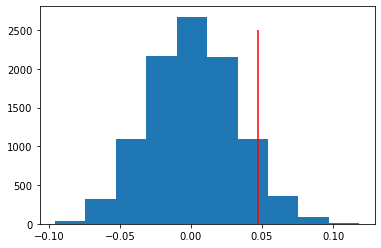

In [9]:
Women1 = WomenOnly[WomenOnly["pclass"]==1].survived
Women2 = WomenOnly[WomenOnly["pclass"]==2].survived

# create a permuation set Women1, Women2 than use the function to create a 1d array with means
perm_reps = draw_perm_reps(Women1, Women2, diff_of_means, 10000)

# critcal val
obsDiff= np.mean(Women1)-np.mean(Women2)
print('Obs Diff: ', obsDiff)

# rechtsseitig
pVal1=np.mean(perm_reps > obsDiff)
print('pVal rechtsseitig: ', pVal1)

# bothsided 
# np.mean you dont have to /len(perm_reps)
# pVal1=np.sum(perm_reps > obsDiff/len(perms_reps))

pVal2=np.mean(np.abs(perm_reps) > obsDiff)
print('pVal abs beidseitig: ', pVal2)

# plot histo
tmp=plt.hist(perm_reps)
# create red line 
plt.vlines(obsDiff,0,2500, color='red')

#### What is the difference between these two methods ?

Testing the hypothesis that two samples have the same distribution may be done with a bootstrap test, but a permutation test is preferred because it is more accurate (exact, in fact). But a permutation test is not as versatile as the bootstrap. 

We often want to test the hypothesis that population A and population B have the same mean, but not necessarily the same distribution. This is difficult with a permutation test as it assumes **exchangeability**.
(https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/20150001882.pdf)

We will get back to this topic!

### 2-sample t test

Of course there is an equivalent fully parametric 2-sample test, the t-test:

In [42]:
preg = pd.read_hdf('data/pregNSFG.h5', 'df')
#only look at live births
live = preg[preg.outcome == 1]

#define first babies
firsts = live[live.birthord == 1]

#and all others:
others = live[live.birthord != 1]

In [45]:
# t test independet two parameters
# equal_var=False trade offs
tRes = stats.ttest_ind(firsts.prglngth.values, others.prglngth.values)

#arrg precision is not working
pd.set_option('precision', 4)
p = pd.Series([tRes.pvalue,tRes.statistic], index = ['p-value', 'test statistic'])

print(p)
# can not reject the h0

p-value           0.1676
test statistic    1.3802
dtype: float64


In [101]:
#ttest_ind often underestimates p for unequal variances:

tRes = stats.ttest_ind(firsts.prglngth.values, others.prglngth.values, equal_var = False)
p = pd.Series([tRes.pvalue,tRes.statistic], index = ['p-value', 'test statistic'])

print(p)

p-value           0.1685
test statistic    1.3771
dtype: float64


Can you reproduce the p-value from the test statistic ?

In [49]:
n1 = len(firsts.prglngth.values)
n2 = len(others.prglngth.values)

# one sided test
pVal = 1-stats.t.cdf(1.3802, n1 + n2 -2)
pVal

# lesson 3 > t test
# maybe not in exam

0.0837794038214007

--------------------------------------------------------
### Random Walks

An illustrative application of basic stochastic concepts in binary processes is the simulation of random walks. Let’s first consider a simple random walk starting at 0 with steps of 1 and -1 occurring with equal probability ($p = 0.5$).


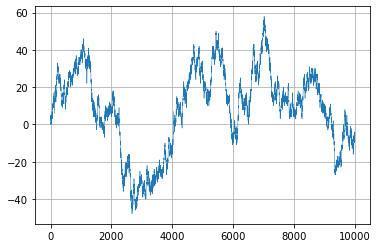

In [12]:
nsteps = 10000
draws = np.random.randint(0, 2, size=nsteps)
steps = np.where(draws > 0, 1, -1)
walk = steps.cumsum()
fig = plt.figure(); ax = fig.add_subplot(1, 1, 1)
ax.plot(walk, linewidth=0.5)
ax.grid()

A more complicated statistic is the first crossing time, the step at which the random walk reaches a particular value. Here we might want to know how long it took the random walk to get at least 10 steps away from the origin 0 in either direction.
np.abs(walk) >= 10 gives us a boolean array indicating where the walk has reached or exceeded 10, but we want the index of the first 10 or -10. This can be computed using argmax, which returns the first index of the maximum value in the boolean
array (True is the maximum value):


In [7]:
(np.abs(walk) >= 10).argmax()

NameError: name 'walk' is not defined

#### Simulating Many Random Walks at Once

If your goal was to simulate many random walks, say 5,000 of them, you can generate all of the random walks with minor modifications to the above code. The numpy.random functions if passed a 2-tuple will generate a 2D array of draws, and we can compute the cumulative sum across the rows to compute all 5,000 random walks in one shot

In [60]:
nwalks = 5000
nsteps = 10000
draws = np.random.randint(0, 2, size=(nwalks, nsteps)) # 0 or 1
steps = np.where(draws > 0, 1, -1)
walks = steps.cumsum(1)

In [61]:
walks.shape

(5000, 10000)

In [76]:
walks[:,1000].shape

(5000,)

In [74]:
# sqrt n law again > not a linear line
# random walks binary data(yes,no: true, false) > helps with testing > 
print(np.std(walks[:,1000])) # 31,6
print(np.std(walks[:,4000])) # 63 doubled even sample has quadruppeld
print(np.std(walks[:,9000])) # 94 tripled even trough sample has increase by factor of nine

31.34773654093705
62.681349825925096
94.80794687029142


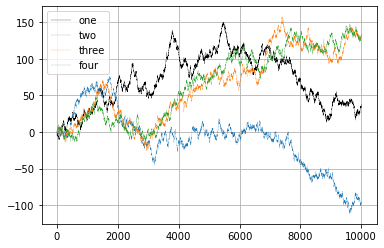

In [62]:
fig = plt.figure(); ax = fig.add_subplot(1, 1, 1)
ax.plot(walks[1,:], 'k', label='one', linewidth=0.25)
ax.plot(walks[2,:], label='two', linestyle ='--', linewidth=0.25)
ax.plot(walks[3,:],  label='three', linestyle ='--', linewidth=0.25)
ax.plot(walks[4,:],  label='four', linestyle ='--', linewidth=0.25)
ax.grid()
#a very useless legend just because we can
ax.legend(loc='best')

Out of these walks, let’s compute the minimum crossing time to 30 or -30. This is slightly tricky because not all 5,000 of them reach 30. We can check this using the *any* method.

We can then use this boolean array to select out the rows of walks that actually cross the absolute 30 level and call argmax across axis 1 to get the crossing times:

In [ ]:
hits30 = (np.abs(walks) >= 30).any(1)
hits30
hits30.sum() # Number that hit 30 or -30

crossing_times = (np.abs(walks[hits30]) >= 30).argmax(1)
crossing_times.mean()

## Tasks

1. Compute the stdev for multiples of 100 iterations and find a pattern
2. Repeat for "biased" random walks, where $p \neq 0.5$. Try $p = 0.1$ and $p = 0.9$
3. Learn
    * the analytic formulae for variance/stdev of coin flips
    * the actual distribution (chap 3.4 in https://www.openintro.org/stat/)
    * its approximation 
4. Complete the labeling of the two axis (with the help of https://codeandstats.shinyapps.io/binomialtails/)
 ![BinomialTails](figures/BinomialTails.png)

### Tasks

1. Explore the *binom* function from scipy.stats
2. Size matters: insurance company A insures 100 cars, company B 400 cars. The probability of a car being stolen is 10%. Compute the probabilities that more than 15% of the respective fleets are stolen.

4. Faced with a mutliple choice test containing 20 question with 4 choices each you decide in desparation to just guess all answers. What is the probability that you will pass, i.e. get at least 10 correct answers?

5. Think about nonparametric versions of the above answers

In [ ]:
 from scipy.stats import binom

### A/B Testing

1. Perform a permutation test on the DataCamp example:

![DC_ABtest.png](figures/DC_ABtest.png)

What does A/B testing have to do with random walks?

Obs Diff:  0.04400000000000001
pVal rechtsseitig:  0.0837794038214007
pVal abs beidseitig:  0.033


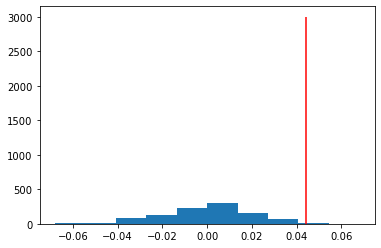

In [59]:
# chapter 4
# two sample test = A/B testing
# significat unlikly due by chance

# we dont have the data we just have the A and B number to shuffle sthg
# creativ solution
clickthroughA = np.array([True] * 45 + [False] * (500-45))
clickthroughB = np.array([True] * 67 + [False] * (500-67))

# create a permuation set Women1, Women2 than use the function to create a 1d array with means
perm_reps = draw_perm_reps(clickthroughB, clickthroughA, diff_of_means, 1000)

# plot histo
tmp=plt.hist(perm_reps)

# create red line 
plt.vlines(obsDiff,0,3000, color='red')

# critcal val
obsDiff= np.mean(clickthroughB)-np.mean(clickthroughA)
print('Obs Diff: ', obsDiff)

# rechtsseitig
pVal1=np.mean(perm_reps >= obsDiff)
print('pVal rechtsseitig: ', pVal)

pVal2=np.mean(np.abs(perm_reps) >= obsDiff)
print('pVal abs beidseitig: ', pVal2)

